# Data preprocessing
- Imported Data from CSV
- Removed irrelavant data(NAN)
- Plotted ax and ay wrt time

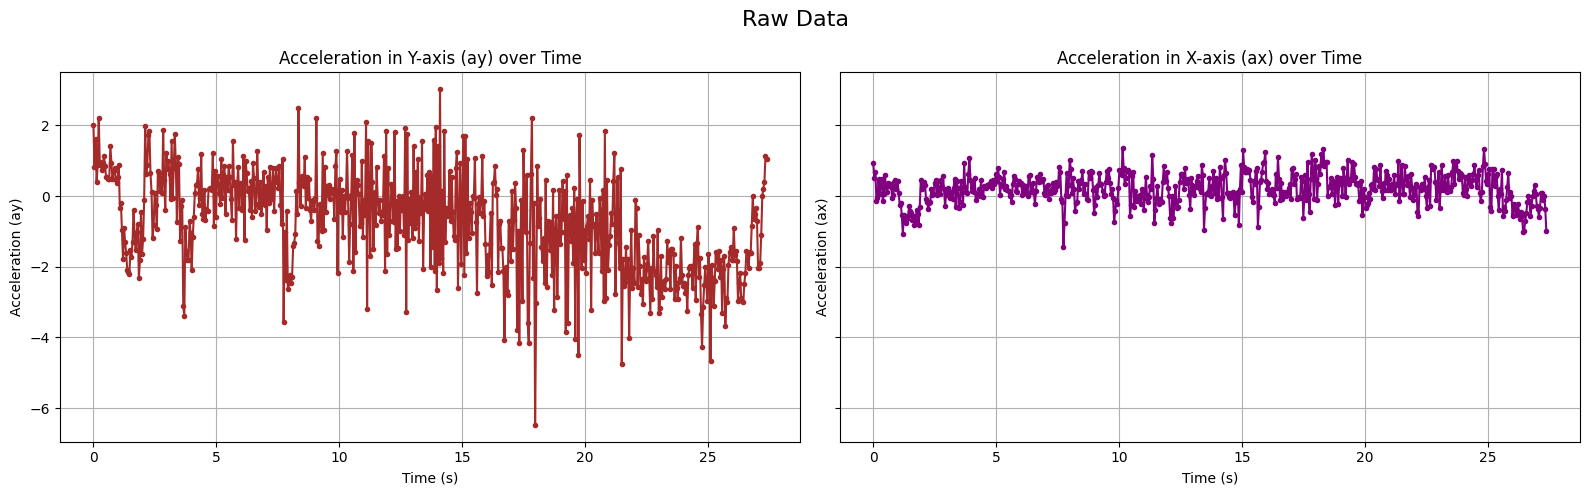

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data1.csv')
# print(df.to_string())
df = df.dropna()
# print(df.to_string())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
fig.suptitle('Raw Data', fontsize=16)
ax1.plot(df['time'], df['ay'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (ay)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (ax)') 
ax2.grid(True)

plt.tight_layout() 
plt.show()


# Exponential Moving Average Filter

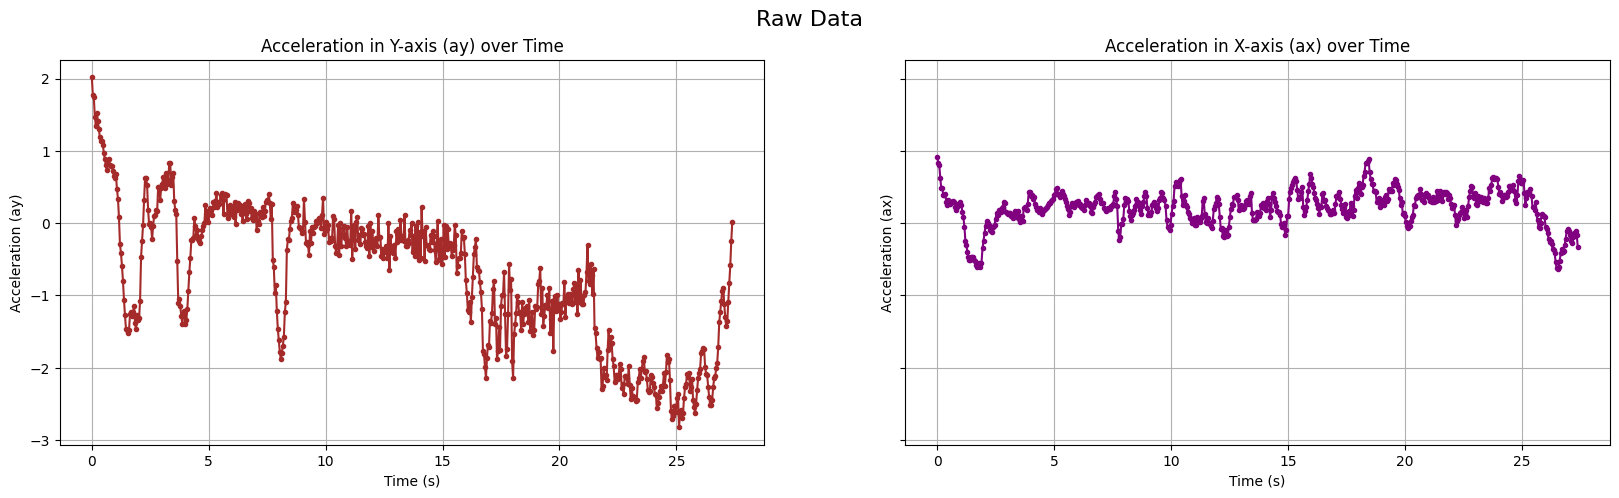

In [9]:
df['ay_new'] = df['ay'].copy()  # Copy ay for filtering
df['ax_new'] = df['ax'].copy()  # Copy ax for filtering

# Apply EMA filter
for i in range(1, len(df)):
    df.loc[i, 'ay_new'] = df.loc[i - 1, 'ay_new'] * 0.8 + df.loc[i, 'ay'] * 0.2
    df.loc[i, 'ax_new'] = df.loc[i - 1, 'ax_new'] * 0.8 + df.loc[i, 'ax'] * 0.2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Raw Data', fontsize=16)
ax1.plot(df['time'], df['ay_new'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (ay)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax_new'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (ax)') 
ax2.grid(True)
